In [1]:
from cpa_utils import *

# Elisabeth-b4 - Filter block

## Debugging S-boxes

In [2]:
traces_path_1 = "..\\acquisition\\debug_sboxes_1\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
ins_outs_path_1 = "..\\acquisition\\debug_sboxes_1\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"
traces_path_2 = "..\\acquisition\\debug_sboxes_2\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
ins_outs_path_2 = "..\\acquisition\\debug_sboxes_2\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"

In [72]:
def load(traces_path, ins_outs_path):
    traces_dict = sio.loadmat(traces_path)
    traces_size = Counter([traces_dict[k][0, 0][4][:, 0].shape[0] for k in traces_dict.keys() if k.startswith("data_")]).most_common(1)[0][0]
    empty_traces = {k for k in traces_dict.keys() if k.startswith("data_") and traces_dict[k][0, 0][4][:, 0].shape[0] != traces_size}
    traces = np.stack([traces_dict[k][0, 0][4][:, 0] for k in traces_dict.keys() if k.startswith("data_") and k not in empty_traces], axis=0)

    inputs_outputs = log_parser.parse(ins_outs_path)
    traces_list = [[], [], [], [], [], []]
    inputs = [[], [], [], [], [], []]
    outputs = [[], [], [], [], [], []]
    i = 0
    for k in traces_dict.keys():
        if k.startswith("data_") and k not in empty_traces:
            ins_out = inputs_outputs[int(k[len("data_"):]) - 1]
            idx = int(ins_out[0][0], 16)
            inputs[idx].append(int(ins_out[0][1], 16) % 16)
            outputs[idx].append(int(ins_out[1], 16))
            traces_list[idx].append(traces[i])
            i += 1

    return traces_list, inputs, outputs

In [74]:
l1 = load(traces_path_1, ins_outs_path_1)
l2 = load(traces_path_2, ins_outs_path_2)
traces, inputs, outputs = [tr1 + tr2 for tr1, tr2 in zip(l1[0], l2[0])], [ins1 + ins2 for ins1, ins2 in zip(l1[1], l2[1])], [out1 + out2 for out1, out2 in zip(l1[2], l2[2])]

In [100]:
def hypotheses(sbox_inputs_all, sbox_outputs_all, sbox_idx):
    return [HW[out] for inp, out in zip(sbox_inputs_all[sbox_idx], sbox_outputs_all[sbox_idx])]

In [97]:
def hypotheses(sbox_inputs_all, sbox_outputs_all, sbox_idx):
    return [HD[out][inp + (sbox_idx << 4)] for inp, out in zip(sbox_inputs_all[sbox_idx], sbox_outputs_all[sbox_idx])]

In [102]:
[[HW[s_boxes_b4[i][j]] for j in range(16)] for i in range(6)]

[[2, 2, 3, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 3, 1, 1],
 [2, 1, 2, 2, 0, 2, 1, 2, 3, 4, 3, 3, 0, 1, 3, 2],
 [3, 3, 3, 1, 2, 2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3],
 [1, 2, 1, 3, 3, 1, 1, 3, 3, 3, 1, 2, 2, 1, 4, 2],
 [3, 2, 4, 2, 0, 0, 2, 0, 2, 3, 1, 3, 0, 0, 1, 0],
 [4, 2, 1, 4, 3, 1, 2, 2, 1, 1, 4, 1, 1, 4, 2, 1]]

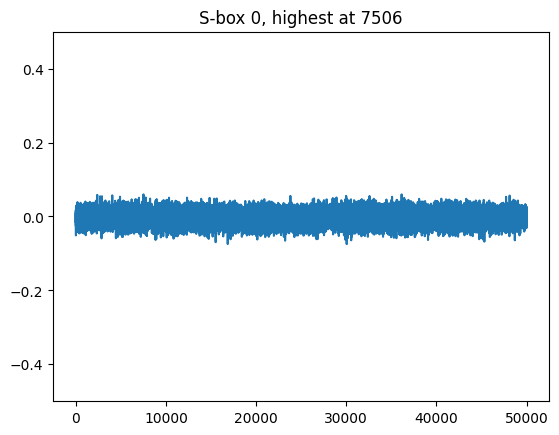

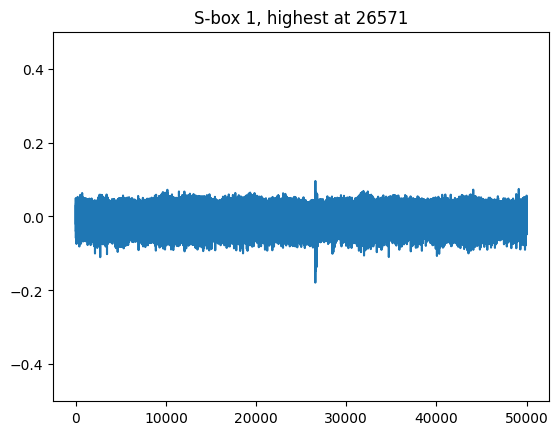

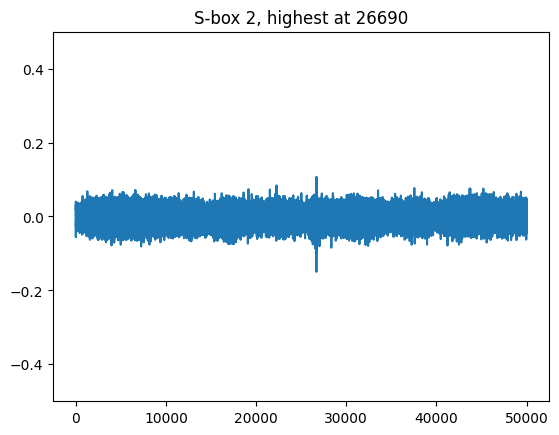

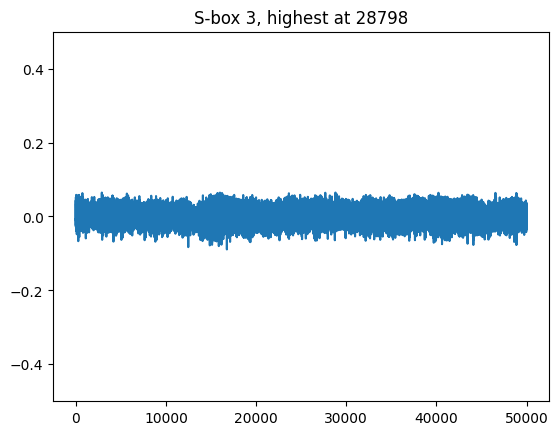

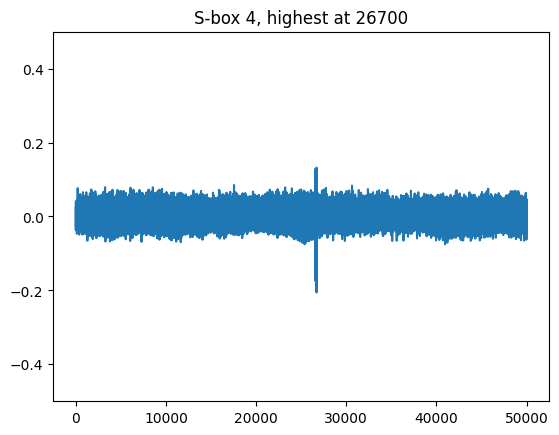

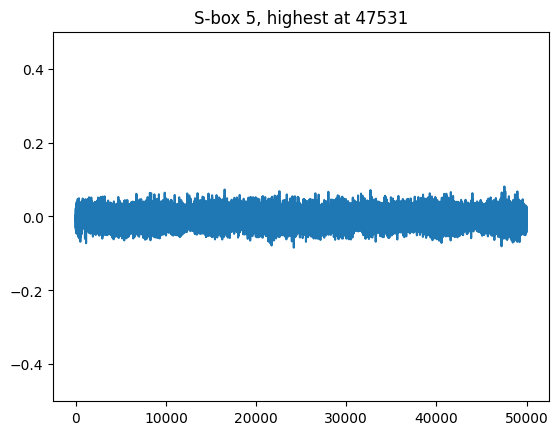

In [101]:
for sbox_idx in range(6):
    corr = corr_coef(np.array(hypotheses(inputs, outputs, sbox_idx)), np.array(traces[sbox_idx]))
    loc = np.argmax(corr)
    plt.plot(corr)
    plt.ylim([-0.5, 0.5])
    plt.title(f"S-box {sbox_idx}, highest at {loc}")
    plt.show()